In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import urllib.request
import numpy as np
import os
from datetime import datetime, timedelta
import bokeh

In [3]:
def fit(data,start,end):
    return np.polyfit(range(len(data[start:end])),data[start:end],1)

def foldingTime(p,fold=2):
    return np.log(fold)/p[0]

def state(state):
    # need to aggregate across counties   
    return df.groupby(['Province_State','Date']).aggregate(sum).loc[state,:]

def country(country):
    # need to aggregate across states/provinces
    return df.groupby(['Country_Region','Date']).aggregate(sum).loc[country,:]

def modelPlot(data, n=7, basey=10, semilogy=True):
    p = fit(np.log(data),-n,len(data))
    p2 = fit(np.log(data),-2*n,-n) 
    
    q = np.polyval(p,range(n))
    q2 = np.polyval(p2,range(2*n))
    
    if semilogy:
        plt.semilogy(range(len(data)),data,'k',lw=4,basey=basey)
        plt.semilogy(range(len(data)-n,len(data)),np.exp(q),'--',color=[0.5,0.5,0.5],lw=4,basey=basey)
        plt.semilogy(range(len(data)-2*n,len(data)),np.exp(q2),'--',color=[0.5,0.5,0.5],lw=4,basey=basey)    
    else:
        plt.plot(range(len(data)),data,'k',lw=4)
        plt.plot(range(len(data)-n,len(data)),np.exp(q),'--',color=[0.5,0.5,0.5],lw=4)
        plt.plot(range(len(data)-2*n,len(data)),np.exp(q2),'--',color=[0.5,0.5,0.5],lw=4)       
    
    line1 = 'Current  2-folding time: ' + str(round(foldingTime(p,2),2)) + ' days'
    line2 = 'Current 10-folding time: ' + str(round(foldingTime(p,10),2)) + ' days'    
    line3 = 'Days Delayed: ' + str(np.round(np.log(np.exp(q2)[-1]/data[-1])/p2[0],2))
    line4 = 'Predicted Within One Day: ' + str(np.round(data[-1]*np.exp(p[0]) - data[-1]))
    plt.title('\n'.join([line1,line2,line3,line4]))

# Data Preparation

In [4]:
data_dir = '/Users/nathankarst/Dropbox/RandomProjects/COVID/COVID data/all/'
data_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/'

In [5]:
yesterday = (datetime.today() + timedelta(-1)).strftime("%m-%d-%Y")

dates = pd.date_range('02-01-2020',yesterday)
dates = [date.strftime('%m-%d-%Y') for date in dates]

dates_old = pd.date_range('02-01-2020','03-21-2020')
dates_old = [date.strftime('%m-%d-%Y') for date in dates_old]

dates_new = pd.date_range('03-22-2020',yesterday)
dates_new = [date.strftime('%m-%d-%Y') for date in dates_new]

In [6]:
for date in dates:
    url = data_url + date + '.csv'
    file = data_dir + date + '.csv'

    if os.path.exists(file): continue
    urllib.request.urlretrieve(url, file)

In [7]:
dfs = []
for date in dates_old:
    df = pd.read_csv(data_dir + date + '.csv')
    df['Date'] = date
    dfs.append(df)

old = pd.concat(dfs)

old = old.rename(columns={'Country/Region':'Country_Region',
            'Province/State':'Province_State',
            'Last Update':'Last_Update',
            'Latitude':'Lat',
            'Longitude':'Long_'})

dfs = []
for date in dates_new:
    df = pd.read_csv(data_dir + date + '.csv')
    df['Date'] = date
    dfs.append(df)

new = pd.concat(dfs)

df = pd.concat([old,new])
df.head()

df.drop(["FIPS","Lat","Long_"],axis=1,inplace=True)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  import sys
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



# Time Series Modeling

Yesterday:


Active           0.0
Confirmed    32829.0
Deaths        1973.0
Recovered     1796.0
Name: 04-08-2020, dtype: float64

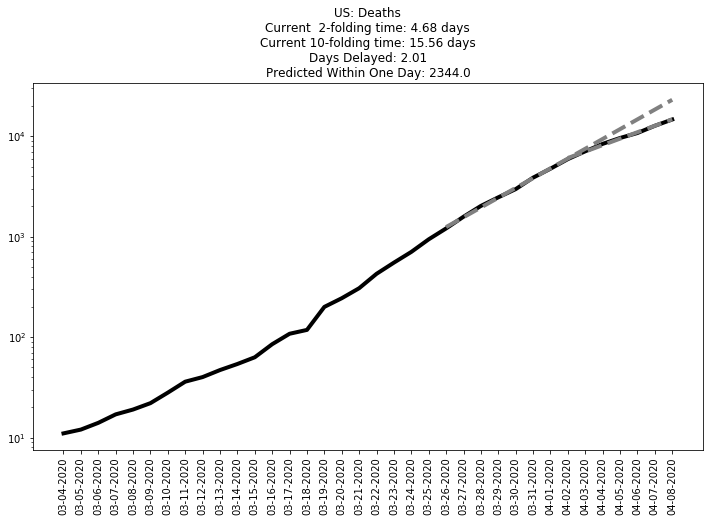

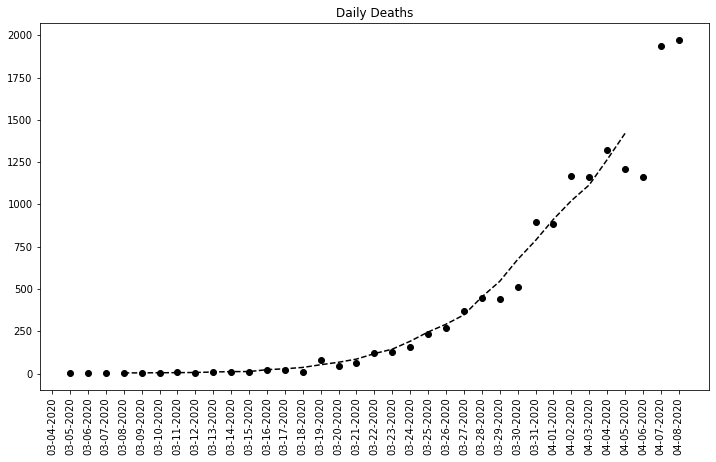

In [9]:
by = "US"
data = country(by)   

field = 'Deaths'
data = data[data[field] > 10]

modelPlot(data[field] ,n=7)
plt.gcf().set_size_inches((12,12*9/16))
plt.title(by + ': ' + field + '\n' + plt.gca().get_title())
plt.xticks(range(len(data)), dates[-len(data):], rotation=90);

daily = data.diff()
plt.figure()
plt.gcf().set_size_inches((12,12*9/16))
plt.plot(daily[field],'ko')
plt.plot(daily[field].rolling(7,center=True).mean(),'k--')
plt.xticks(range(len(data)), dates[-len(data):], rotation=90);
plt.title('Daily ' + field);

print('Yesterday:')
daily.iloc[-1,:]

Yesterday:


Active          0.0
Confirmed    1588.0
Deaths         77.0
Recovered       0.0
Name: 04-08-2020, dtype: float64

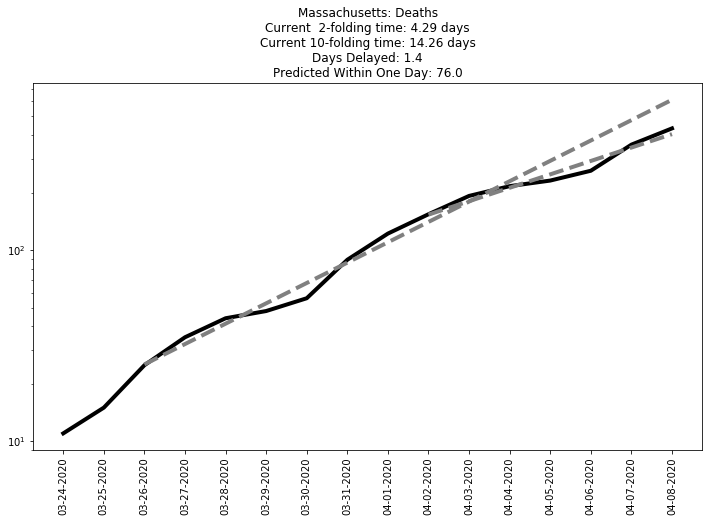

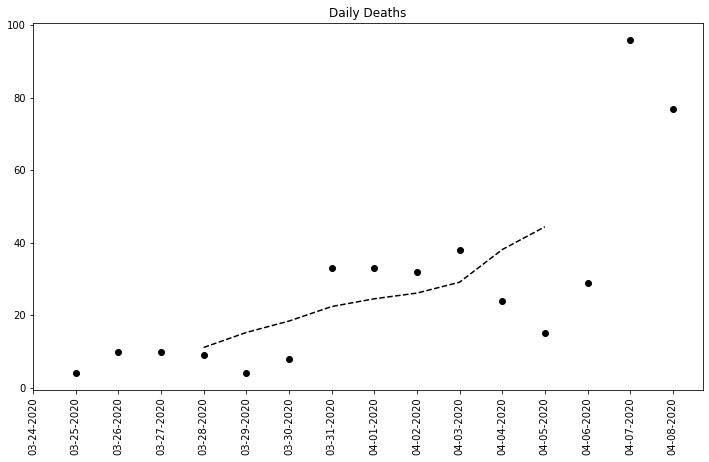

In [11]:
by = "Massachusetts"
# by = "New York"
# by = "California"
# by = 'Florida'

field = 'Deaths'
data = state(by)
data = data[data[field] > 10]

modelPlot(data[field] ,n=7)
plt.gcf().set_size_inches((12,12*9/16))
plt.title(by + ': ' + field + '\n' + plt.gca().get_title())
plt.xticks(range(len(data)), dates[-len(data):], rotation=90);

daily = data.diff()
plt.figure()
plt.gcf().set_size_inches((12,12*9/16))
plt.plot(daily[field],'ko')
plt.plot(daily[field].rolling(7,center=True).mean(),'k--')
plt.xticks(range(len(data)), dates[-len(data):], rotation=90);
plt.title('Daily ' + field);

print('Yesterday:')
daily.iloc[-1,:]

# Stacked Bar Time Series

Text(0.5, 1.0, 'Normalized Daily Deaths')

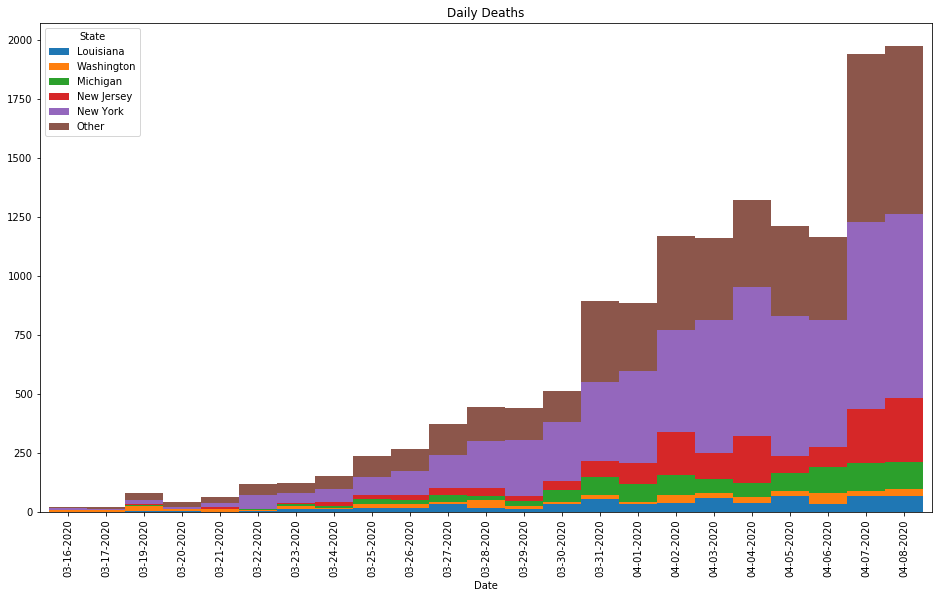

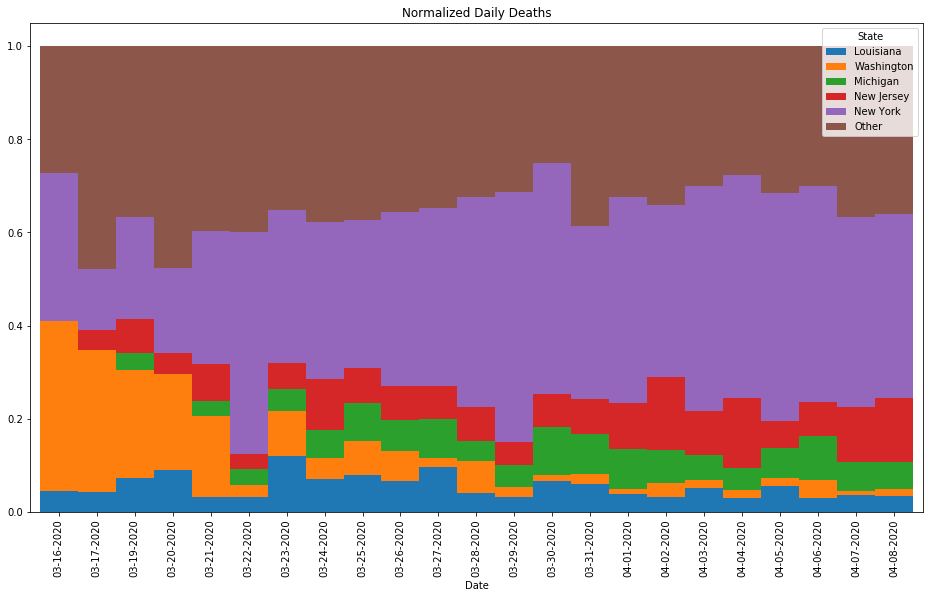

In [12]:
field = 'Deaths'
N = 5 # too messy if we show all states... just show top N and sum remaining to "Other"

us = df.loc[df['Country_Region'] == "US"]
us = us.loc[us['Date'] >= '03-01-2020']
us = us.groupby(['Date','Province_State']).aggregate(sum).reset_index()
us = us.rename(columns={'Province_State':'State'})
us = us.pivot(index='Date',columns='State',values=field)

# thanks to manjeet_04! https://www.geeksforgeeks.org/python-indices-of-n-largest-elements-in-list/
def idxOfLargestNItemsFrom(x,N=1):
    return sorted(range(len(x)), key = lambda sub: x[sub])[-N:] 

highest = us.columns[idxOfLargestNItemsFrom(us.sum(axis=0),N)]

daily = us.diff(axis=0)

daily_highest = daily.loc[:,highest]
daily_highest['Other'] = daily.drop(highest,axis=1).sum(axis=1)

daily_highest = daily_highest.loc[daily_highest.sum(axis=1) > 10, :]


daily_highest.plot.bar(stacked=True, figsize=(16,9), width=1)
plt.title('Daily ' + field )

daily_highest.div(daily_highest.sum(axis=1),axis=0).plot.bar(stacked=True, figsize=(16,9), width=1)
plt.title('Normalized Daily ' + field )

# Lagging

Active          0.0
Confirmed    1588.0
Deaths         77.0
Recovered       0.0
Name: 04-08-2020, dtype: float64


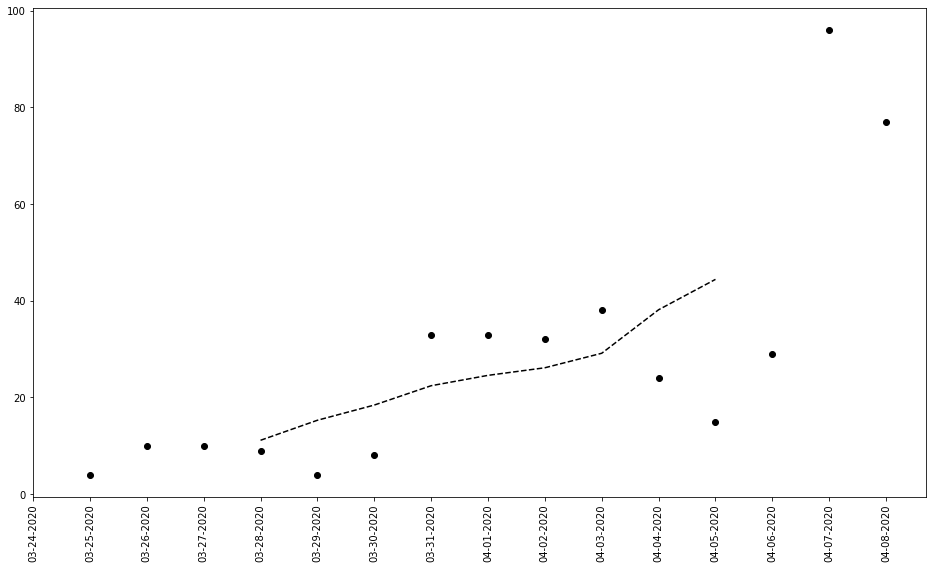

In [40]:
daily = data.diff()
plt.figure(figsize=(16,9))
plt.plot(daily[field],'ko')
plt.plot(daily[field].rolling(7,center=True).mean(),'k--')
plt.xticks(range(len(data)), dates[-len(data):], rotation=90);
print(daily.iloc[-1,:])

In [219]:
country1 = "US"
country2 = "Italy"

c1 = country(country1)['Confirmed'][-30:]
c2 = country(country2)['Confirmed'][-30:]

Text(0.5, 0, '$\\tau$')

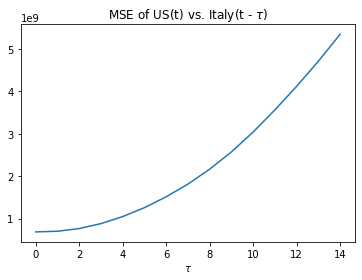

In [220]:
tau_max = 15
err = np.zeros(tau_max)

err[0] = np.mean((c1-c2)**2)
for tau in range(1,tau_max):
    err[tau] = np.mean((np.array(c1[tau:]) - np.array(c2[:-tau]))**2)
    
tau = list(range(tau_max))
plt.plot(tau, err)
plt.title('MSE of ' + country1 + '(t) vs. ' + country2 + r'(t - $\tau$)')
plt.xlabel(r'$\tau$')

# Bayesian Analysis of Likely Number of Total Cases

In [84]:
file = '/Users/nathankarst/Dropbox/RandomProjects/COVID/data/tests.csv'
url = 'http://covidtracking.com/api/states/daily.csv'
urllib.request.urlretrieve(url, file);

FileNotFoundError: [Errno 2] No such file or directory: '/Users/nathankarst/Dropbox/RandomProjects/COVID/data/tests.csv'

In [85]:
tests = pd.read_csv('/Users/nathankarst/Dropbox/RandomProjects/COVID/data/tests.csv')
pop = pd.read_csv('/Users/nathankarst/Dropbox/RandomProjects/COVID/data/population.csv')
pop['Population'] = pop['Population'].str.replace(',', '')
pop['Population'] = pd.to_numeric(pop['Population'])

x = pd.merge(tests,pop,left_on='state',right_on='Abbreviation')

FileNotFoundError: [Errno 2] File b'/Users/nathankarst/Dropbox/RandomProjects/COVID/data/tests.csv' does not exist: b'/Users/nathankarst/Dropbox/RandomProjects/COVID/data/tests.csv'

In [83]:
date = '2020-03-24' + 'T20:00:00Z'
state = 'MA'
p_test_given_pos = 0.1

lim = x.loc[(x['dateChecked'] == date) & (x['state'] == state)]
lim.head()

n_pos_test = lim['positive'].iloc[0]
p_pos_given_test = lim['positive'].iloc[0]/lim['total'].iloc[0]
p_test = lim['total'].iloc[0]/lim['Population'].iloc[0]

p_pos = p_test*p_pos_given_test/p_test_given_pos
n_pos = np.round(p_pos*lim['Population'].iloc[0])

print(p_pos_given_test)
print('P(Corona) = ',p_pos)
print('N(Corona) = ',n_pos)
print('N(Corona)/N(pos test) = ',n_pos/n_pos_test)

0.08429703978471162
P(Corona) =  0.0016815371716196567
N(Corona) =  11590.0
N(Corona)/N(pos test) =  10.0
